In [10]:
import re
import os
import pathlib
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import gridspec
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_theme(style="darkgrid")

# Root of the project
project_dir = pathlib.Path().resolve().parent

# Directory containing experiment results
results_dir = (pathlib.Path(project_dir) / "results").resolve()

# Directory for tidied data (output directory)
data_dir = (pathlib.Path(project_dir) / "data").resolve()

# Directory to store all plots
plot_dir = (pathlib.Path(project_dir) / "plots").resolve()



# Experiment constants
exp_name = "01_http_max_throughput"
file_prefix = "exp-01"

In [11]:
"""Load cleaned/aggregated data sets

Also fixes type hinting for pandas

resource_df -> CPU/Mem utilization for experiments
fortio_df -> Load test results from fortio
"""

resource_df = pd.read_csv(
    data_dir / "resource_results.feather",
    dtype={
        # "experiment": "category",
        # "mesh": "category",
        # "requested_qps": "category",
        "pod": "string",
        "container": "string",
    },
    parse_dates=["date"],
)


fortio_df = pd.read_feather(
    data_dir / "fortio_results.feather",
    # dtype={
    #     # "experiment": "category",
    #     # # "mesh": "category",
    #     # "requested_qps": "category",
    #     # "protocol": "category",
    #     # "payload": "category",
    #     "actual_qps": "float64",
    #     "latency": "float64",
    # },
    # parse_dates=["date"],
)

In [12]:
"""
Prepares the experiment data

"""

df =  fortio_df[fortio_df["experiment"] == "01_http_max_throughput"]
df = df.sort_values("actual_qps")

exp = fortio_df[fortio_df["experiment"] == "01_http_max_throughput"]
exp = exp.drop("actual_qps", 1)
exp = exp.explode("latency")
exp = exp.reset_index(drop=True)
exp = exp.astype({
    "latency": np.float64
})

exp = exp.sort_values("mesh")


exp.head()

,experiment,mesh,requested_qps,protocol,payload,latency
39588490,01_http_max_throughput,Baseline,MAX,http,0,1.212712
41873570,01_http_max_throughput,Baseline,MAX,http,0,1.552183
41873569,01_http_max_throughput,Baseline,MAX,http,0,1.412421
41873568,01_http_max_throughput,Baseline,MAX,http,0,1.476801
41873567,01_http_max_throughput,Baseline,MAX,http,0,1.567548


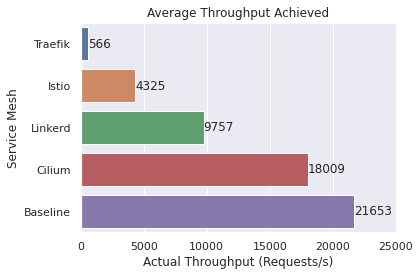

In [13]:
"""
PLOT: Bar Chart
Desc: Average Throughput per service mesh
"""

file_name = f"{file_prefix}-bar_avg_throughput.pdf"


fig, ax = plt.subplots()
ax = sns.barplot(data=df, x="actual_qps", y="mesh", ax=ax)

ax.set_xlim(0, 25000)


# # Show numbers on top of bars
ax.bar_label(ax.containers[0], label_type="edge", fmt="%.0f")

ax.set_xlabel("Actual Throughput (Requests/s)")
ax.set_ylabel("Service Mesh")
ax.set_title("Average Throughput Achieved")


fig.tight_layout()
fig.savefig(plot_dir / file_name)


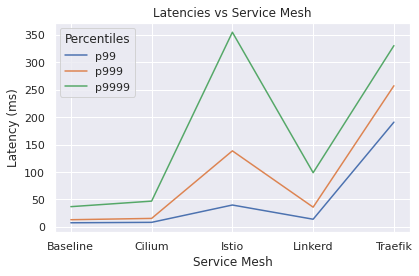

In [14]:
"""
PLOT: Line Plot
Desc: Tail end latencies (high percentiles)
"""

file_name = f"{file_prefix}-line_tail_latencies.pdf"

# The quantiles to plot
quantiles = [
    0.99,
    0.999,
    0.9999
]
data = exp.groupby("mesh")["latency"].quantile(quantiles).unstack()

fig, ax = plt.subplots()
ax = sns.lineplot(data=data, dashes=False, ax=ax)

ax.set_xlabel("Service Mesh")
ax.set_ylabel("Latency (ms)")

ax.set_title("Latencies vs Service Mesh")

ax.legend(["p99", "p999", "p9999"], title= "Percentiles")

fig.tight_layout()
fig.savefig(plot_dir / file_name)

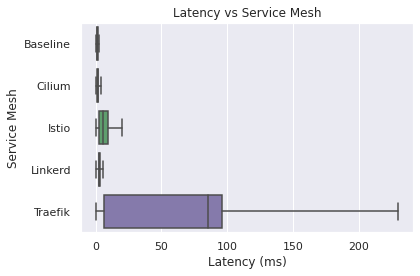

In [15]:
"""
PLOT: Boxplot latency by mesh
Desc: Show 25p med 50p latencies
"""

file_name = f"{file_prefix}-box_latency.pdf"
plot_title = "Latency vs Service Mesh"

fig, ax = plt.subplots()
ax = sns.boxplot(data=exp, x="latency", y="mesh", showfliers=False)

# Labels
ax.set_ylabel("Service Mesh")
ax.set_xlabel("Latency (ms)")
ax.set_title(plot_title)

# ax.set_xscale("log")


fig.tight_layout()
fig.savefig(plot_dir / file_name)

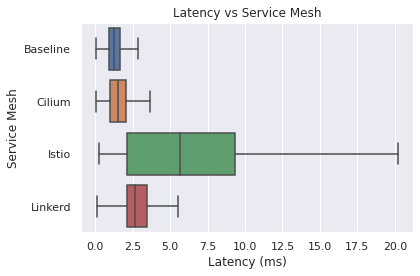

In [16]:
"""
PLOT: Boxplot latency by mesh
Desc: Show 25p med 50p latencies without traefik
"""

file_name = f"{file_prefix}-box_latency-no-traefik.pdf"
plot_title = "Latency vs Service Mesh"

data = exp[exp["mesh"] != "Traefik"]
data = data.sort_values("mesh")

fig, ax = plt.subplots()
ax = sns.boxplot(data=data, x="latency", y="mesh", showfliers=False)

# Labels
ax.set_ylabel("Service Mesh")
ax.set_xlabel("Latency (ms)")
ax.set_title(plot_title)

# ax.set_xscale("log")


fig.tight_layout()
fig.savefig(plot_dir / file_name)

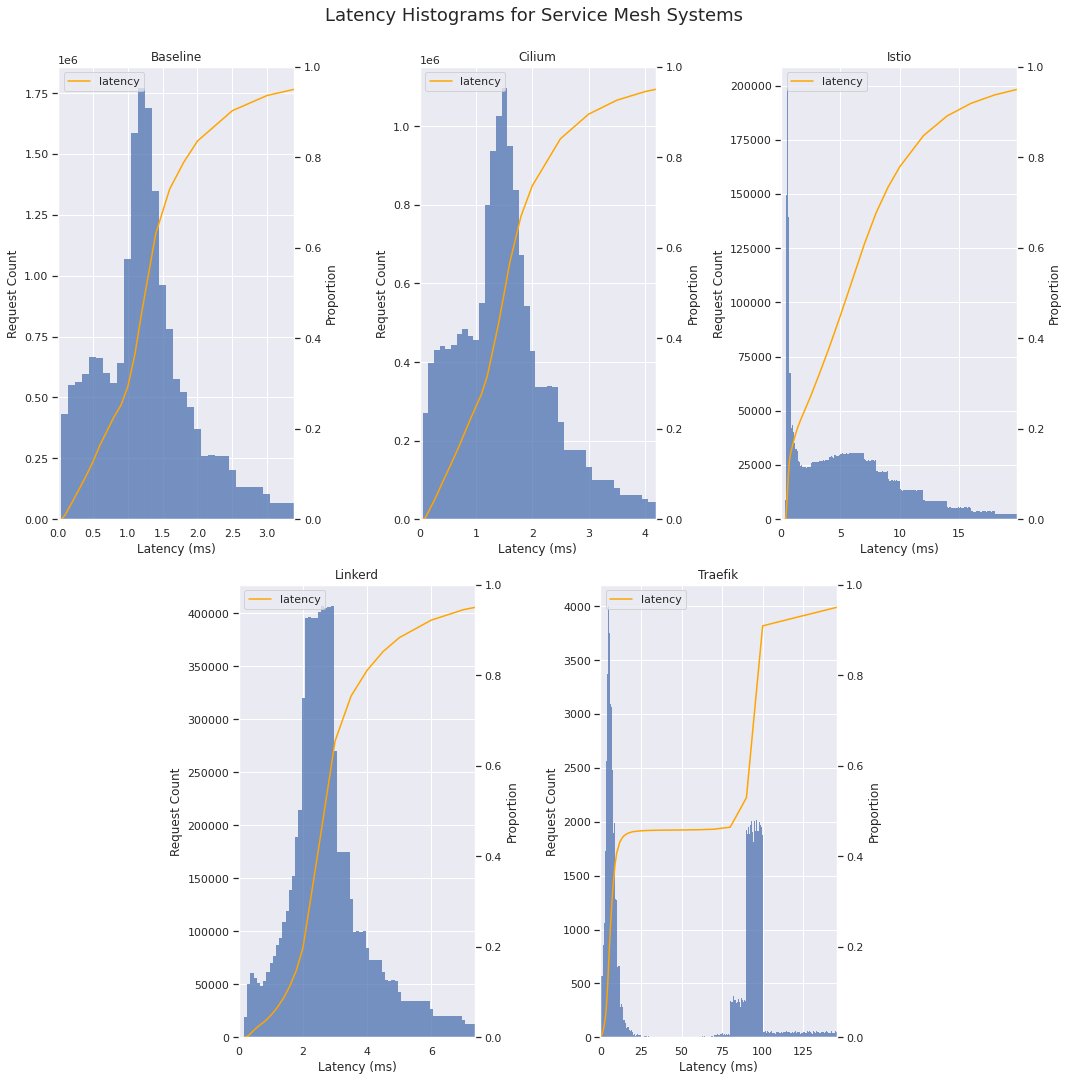

In [17]:

"""
PLOT: Histogram plots
Desc: 
"""

file_name = f"{file_prefix}-hist_latencies.pdf"

# Create grid of plots
fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(nrows=2, ncols=6)

# Create subplots, each plot is 2 cols wide
axes=[
    # Row 0
    fig.add_subplot(gs[0, 0:2]),
    fig.add_subplot(gs[0, 2:4]),
    fig.add_subplot(gs[0, 4:6]),
    # Row 1 (offset by 1)
    fig.add_subplot(gs[1, 1:3]),
    fig.add_subplot(gs[1, 3:5]),
]

# Set figure title
fig.suptitle("Latency Histograms for Service Mesh Systems", fontsize=18, y=1)

mesh_configs = exp["mesh"].unique()

for i, m in enumerate(mesh_configs):
    data = exp[exp["mesh"] == m]
    # filtered = data[data["latency"] < data["latency"].quantile(.95)]

    ax = axes[i]

    sns.histplot(data=data, x="latency", binwidth=.1, ax=ax)

    # Labels
    # plot_title = (
    #     f"$\\bf{row['mesh'].capitalize()}$\n"
    #     f"RPS: {row['ActualQPS']:.0f}\n"
    #     f"min: {row['Min']:.2f} ms, avg: {row['Avg']:.2f} ms, max: {row['Max']:.2f} ms"
    # )
    ax.set_ylabel("Request Count")
    ax.set_xlabel("Latency (ms)")
    ax.set_title(m)


    # Y AXIS
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())


    # X AXIS
    ax.set_xlim(0, data["latency"].quantile(.95))
    # ax.set_xscale("log")
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())


    # Second plot with cumulative density
    ax2 = ax.twinx()
    ax2.set_alpha(0.5)
    ax2.grid(False)
    sns.ecdfplot(data=data, palette=["orange"], ax=ax2)


fig.tight_layout()
fig.savefig(plot_dir / file_name)

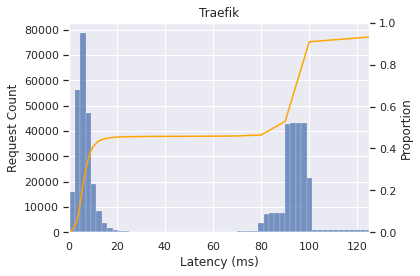

In [18]:
"""
PLOT: Histplot of Traefik mesh
Desc: Shows bimodal nature of traefik mesh latencies
"""

file_name = f"{file_prefix}-hist-traefik.pdf"
plot_title = "Histogram of Traefik Latencies"

data = exp[exp["mesh"] == "Traefik"]

fig, ax = plt.subplots()
sns.histplot(data=data, x="latency", ax=ax)

ax.set_ylabel("Request Count")
ax.set_xlabel("Latency (ms)")
ax.set_title(m)


# Y AXIS
# ax.yaxis.set_major_formatter(ticker.ScalarFormatter())


# X AXIS
ax.set_xlim(0, 125)
# ax.set_xscale("log")
# ax.xaxis.set_major_formatter(ticker.ScalarFormatter())


# Second plot with cumulative density
ax2 = ax.twinx()
ax2.set_alpha(0.5)
ax2.grid(False)
sns.ecdfplot(data=data, palette=["orange"], ax=ax2)
ax2.get_legend().remove()

fig.tight_layout()
fig.savefig(plot_dir / file_name)